In [1]:
from PIL import Image
import numpy as np
import diplib
from PIL import ImageFilter
import astroalign as aa
import cv2
import sys
from common_functions import *

sys.setrecursionlimit(530000) # override needed for computing midpoints, which uses a recursive function
Image.MAX_IMAGE_PIXELS = 366498276 # override is needed, or else it gives a DecompressionBombError

# cy1_file = 'originals/ImageSLIDE4-CYCLE1.tif'
# cy2_file = 'originals/ImageARRAY4-CYCLE2.tif'
# cy1_shifted_file = "originals/shiftedCycle1.tif"
# cy2_shifted_file = "originals/shiftedCycle2.tif"

cy1_file = 'originals/cycle 1thnksgv.tif'
cy2_file = 'originals/cycle 2thnksgv.tif'
cy1_shifted_file = "originals/shiftedcycle 1thnksgv.tif"
cy2_shifted_file = "originals/shiftedcycle 2thnksgv.tif"


DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


<function c at 0x10d3f7240>


In [4]:
## open tiffs
## lower res

layer_to_align = 0

img_cy1 = Image.open(cy1_file)
img_cy1.seek(layer_to_align) # navigate to brightfield
brightfield_cy1 = np.array(img_cy1)
brightfield_cy1 = (brightfield_cy1/256).astype('uint8') # don't need the whole range of values, so this reduces mem size, + improves access speed

img_cy2 = Image.open(cy2_file)
img_cy2.seek(layer_to_align) # navigate to brightfield
brightfield_cy2 = np.array(img_cy2)
brightfield_cy2 = (brightfield_cy2/256).astype('uint8') 


(1732, 1659) (1688, 1732)
(1732, 1732)


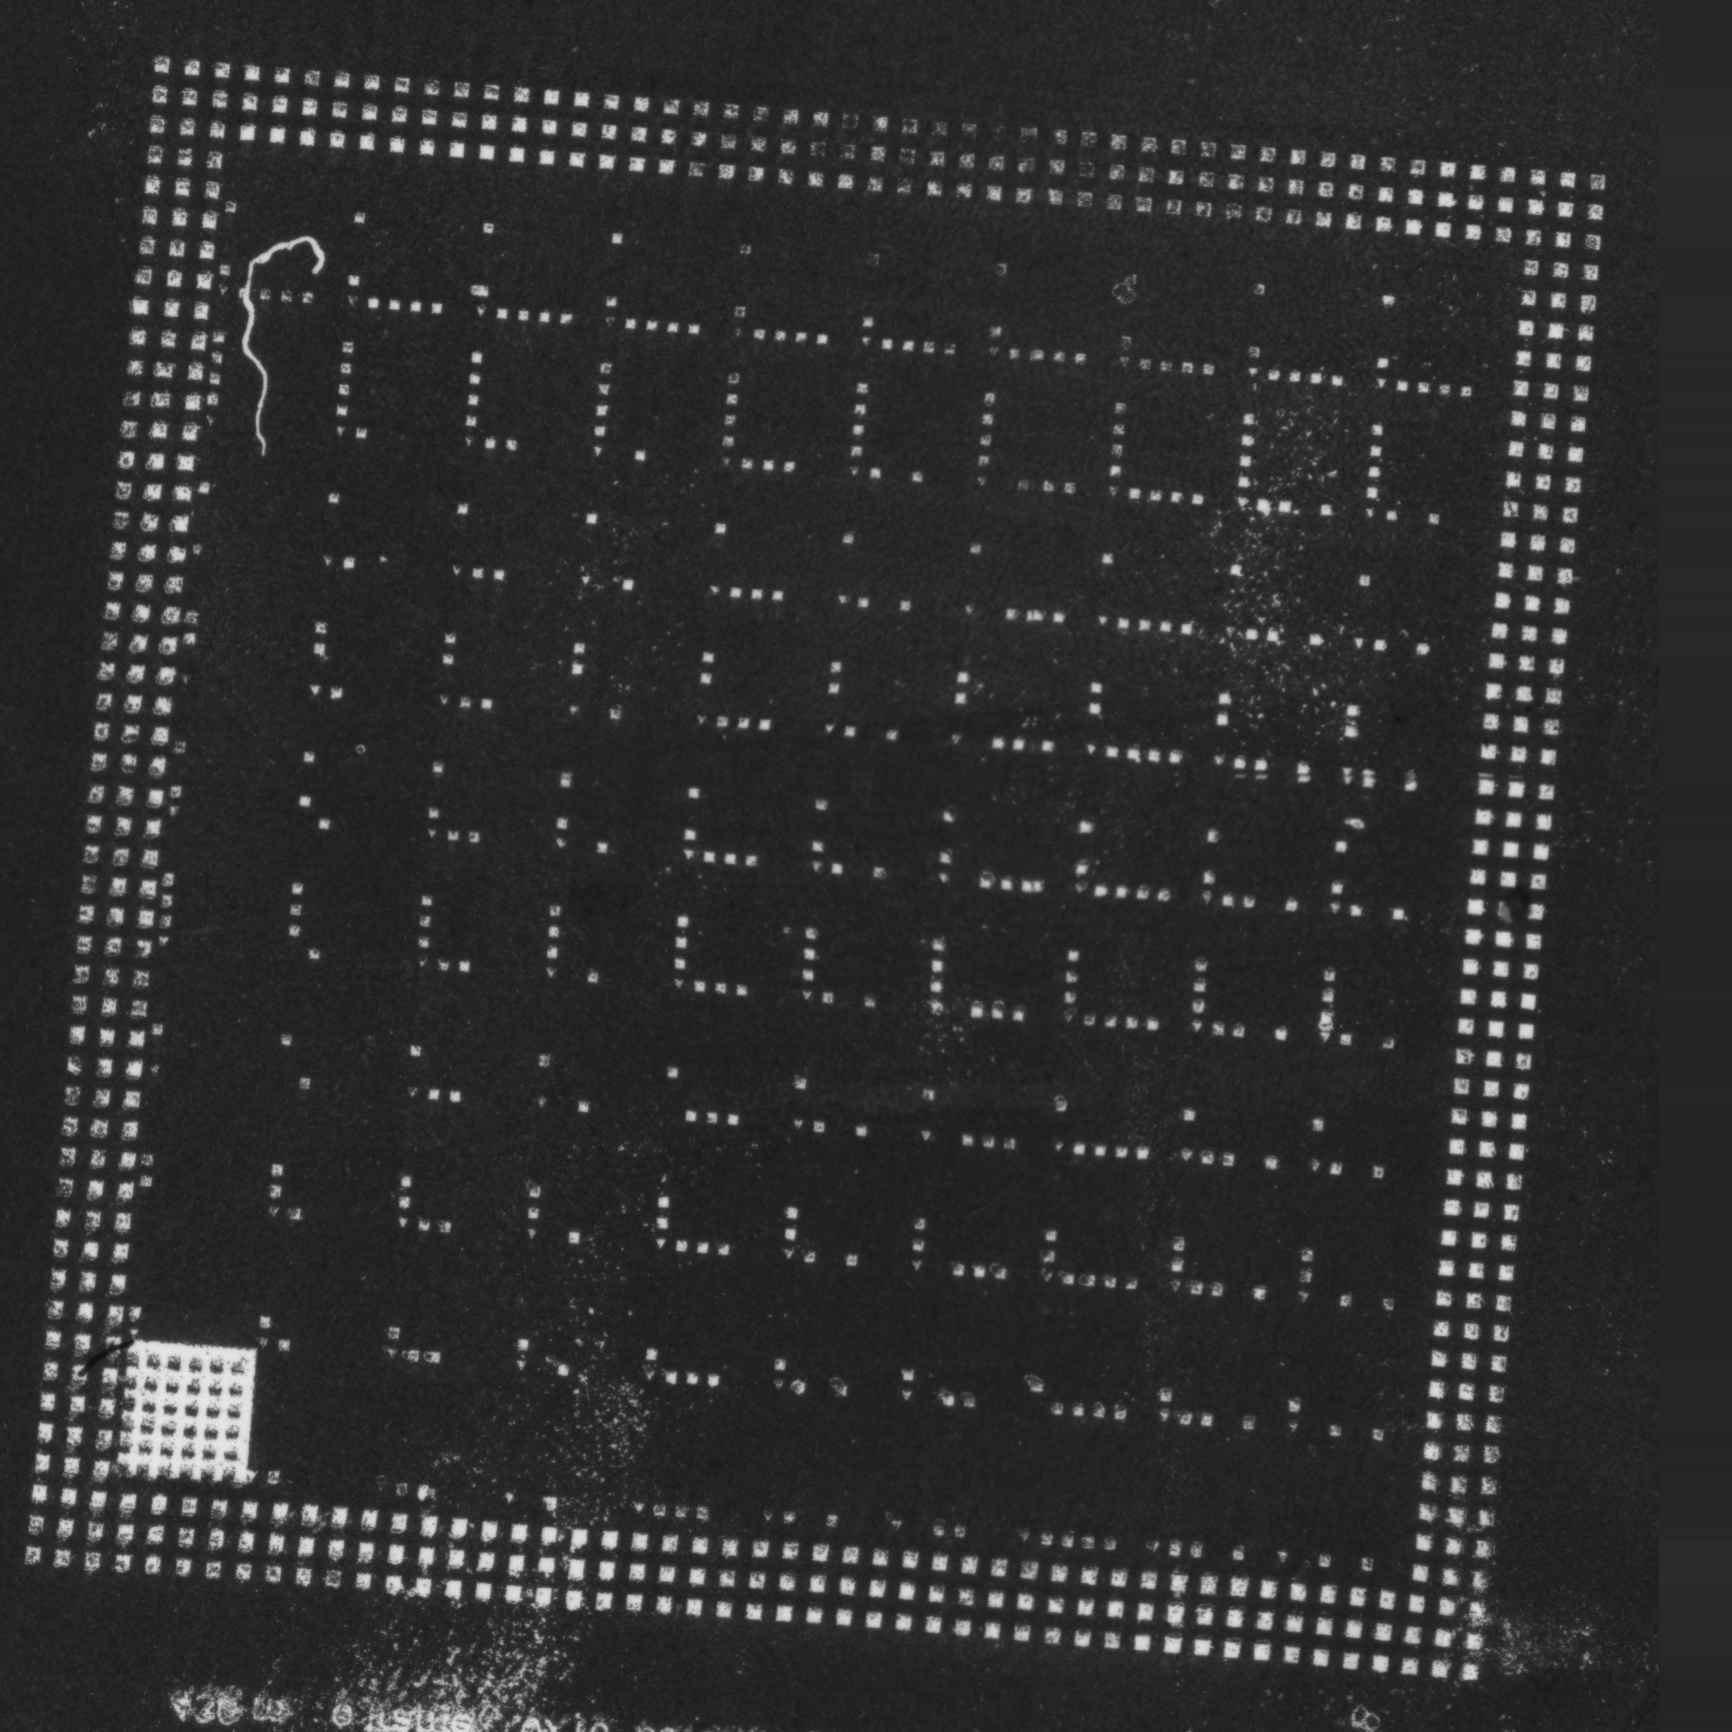

In [5]:
# The code seeks to fix the following problem:
# PROBLEM: the two images have different sizes, so when you attempt to scale them down, they get squished
y_cf1, x_cf1 = brightfield_cy1.shape
y_cf2, x_cf2 = brightfield_cy2.shape
max_dim = max(x_cf1, x_cf2, y_cf1, y_cf2)


scale_down_factor = 1 if max_dim < 3000 else round(max_dim / 3000)

new_size = max_dim // scale_down_factor

print(brightfield_cy1.shape, brightfield_cy2.shape)

brightfield_cy1_padded = np.pad(brightfield_cy1, pad_width=((max_dim-y_cf1, 0), (0, max_dim-x_cf1)), mode = 'median')
brightfield_cy2_padded = np.pad(brightfield_cy2, pad_width=((max_dim-y_cf2, 0), (0, max_dim-x_cf2)), mode = 'median')

print(brightfield_cy1_padded.shape)

brightfield_cy1_reduced = cv2.resize(brightfield_cy1_padded, (new_size, new_size)) # 96.5% smaller = faster
brightfield_cy2_reduced = cv2.resize(brightfield_cy2_padded, (new_size, new_size)) # 96.5% smaller = faster

### DONT DELETE!    visual
# c_many([brightfield_cy1, resized_down ], ["Cycle 1 (original)", "Cycle 1 (reduced)"])

c(brightfield_cy1_reduced)

In [6]:
### clean up
img_cy1 = None
img_cy2 = None
brightfield_cy1 = None
brightfield_cy2 = None
brightfield_cy1_padded = None
brightfield_cy2_padded = None

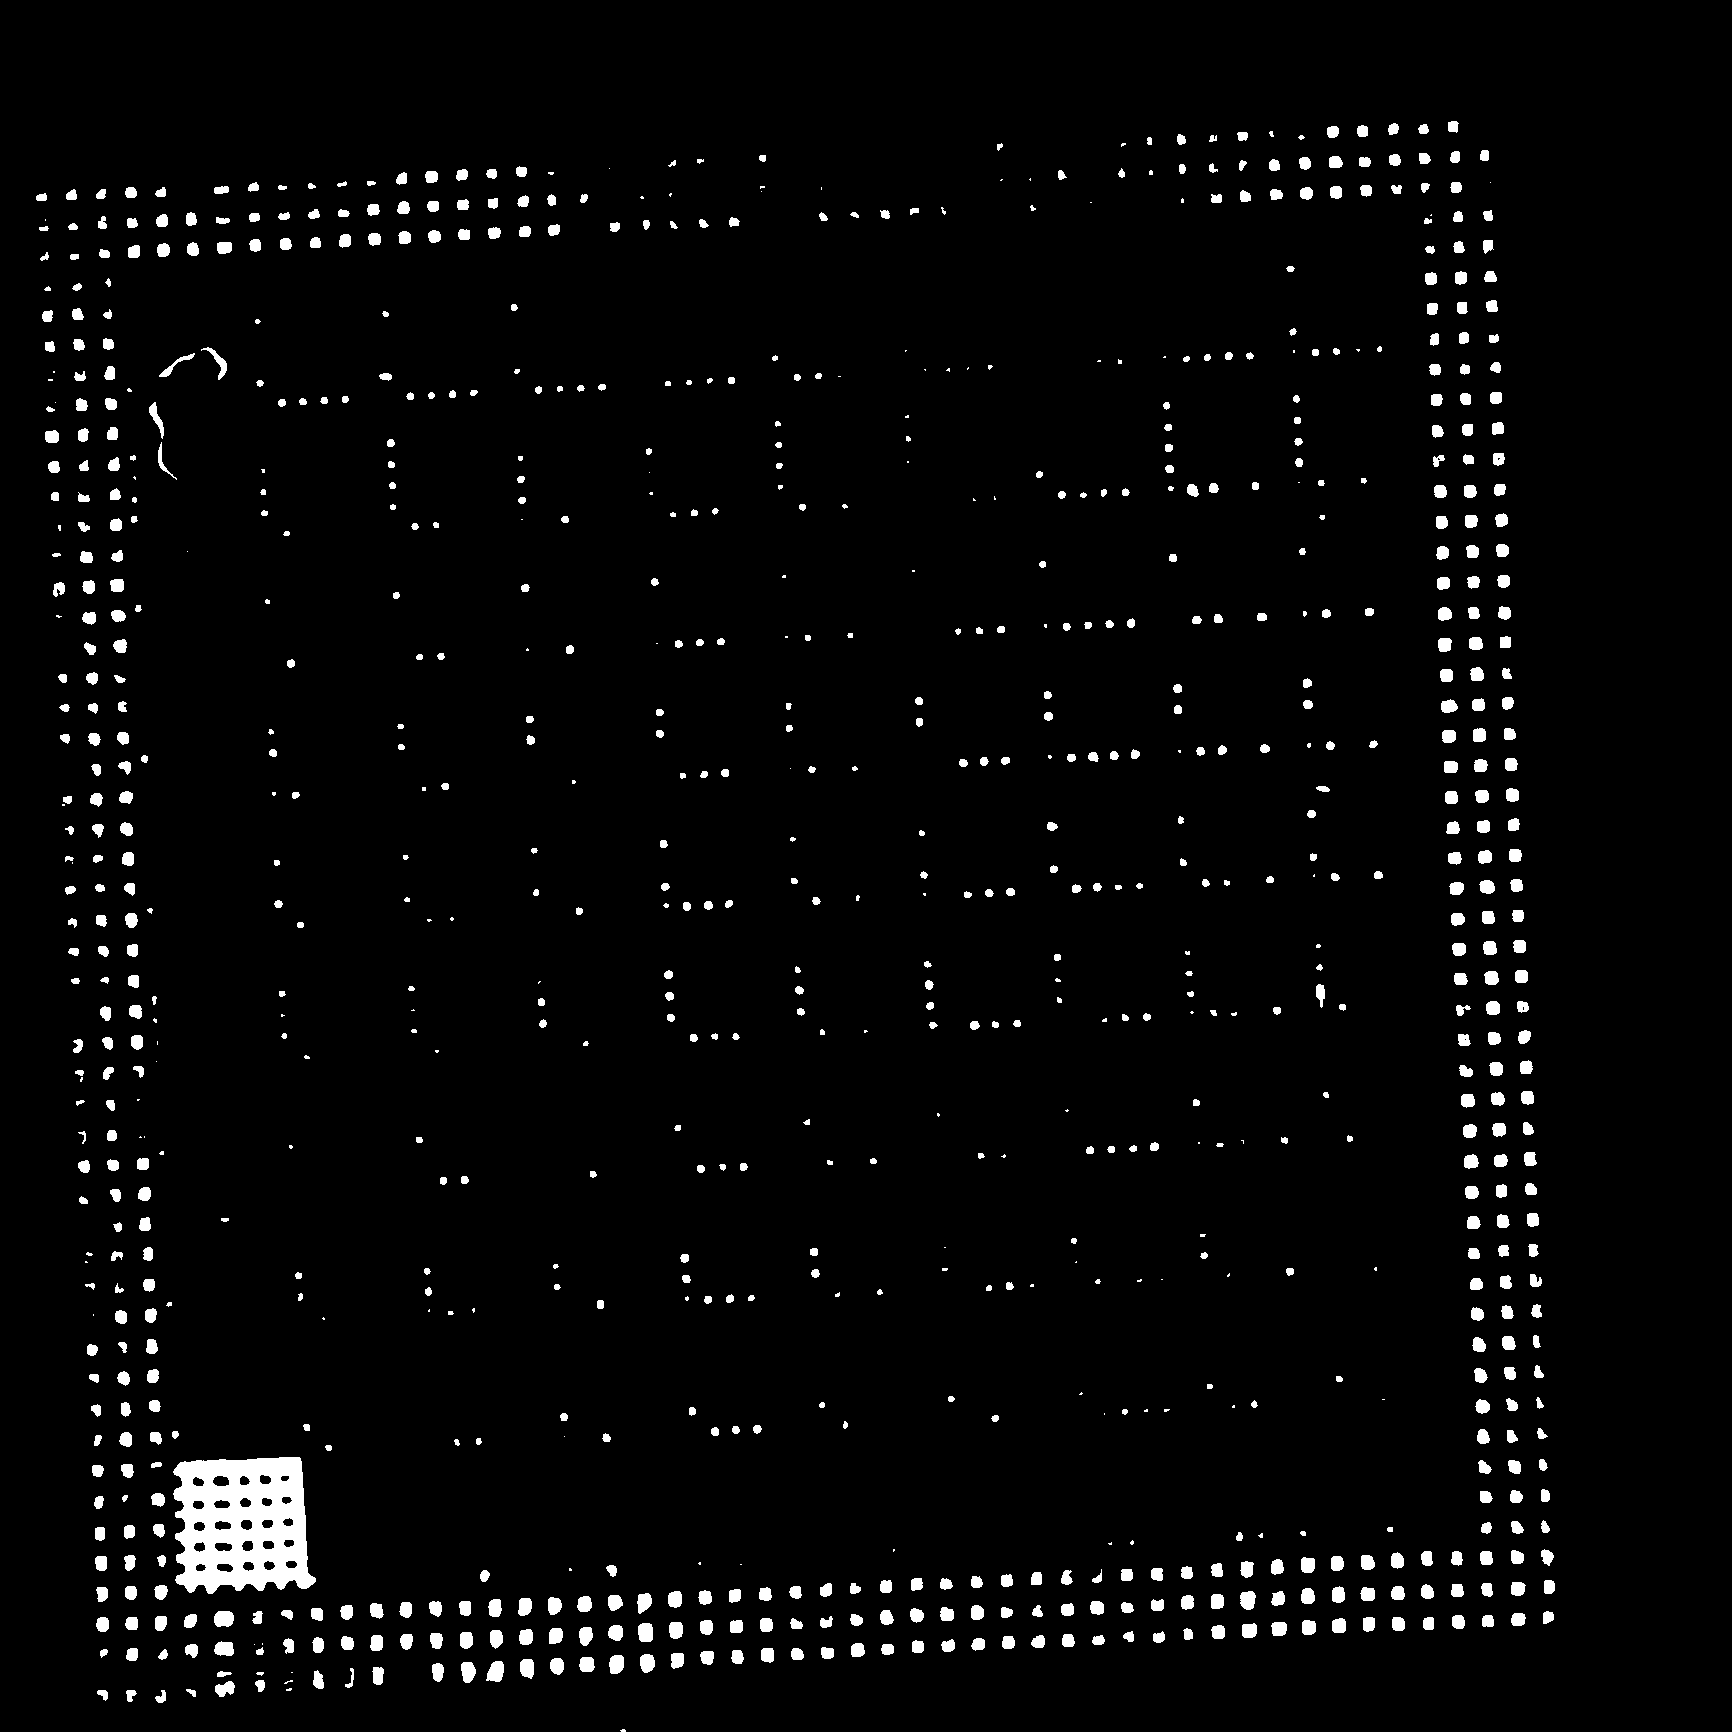

In [17]:

bf_cy1_processed = blur_noise_reduction((brightfield_cy1_reduced))
bf_cy1_thresholded = threshold(bf_cy1_processed, 97)


bf_cy2_processed = blur_noise_reduction((brightfield_cy2_reduced))
bf_cy2_thresholded = threshold(bf_cy2_processed, 97)



c(bf_cy2_thresholded)

In [8]:
# the next few sections of code find center points

def get_center_points(mat_orig, min_size=0):
    mat = (mat_orig == 255)
    gray_edit_copy = mat_orig.copy()

    def fill_blob(x, y):
        
        mat[y][x] = False
        blob_elems = [[x, y]]
        #  right
        if  (x != mat.shape[1] - 1) and mat[y][x+1]:
            blob_elems +=(fill_blob(x+1, y))
        # down
        if  (y != mat.shape[0] - 1) and mat[y+1][x]:
            blob_elems +=(fill_blob(x, y+1))
        # left
        if  (x != 0) and mat[y][x-1]:
            blob_elems +=(fill_blob(x-1, y))
        # up
        if  (y != 0) and  mat[y-1][x]:
            blob_elems +=(fill_blob(x, y-1))
        
        
        
        
        
        
        
        return blob_elems

    
    midpoints = []
    sizes = []
    for y, line in enumerate(mat):
        for x, pixel in enumerate(line):
            if pixel:
                points = fill_blob(x, y)
                if len(points) > min_size :
                    midpoints.append([ round(x) for x in list(np.average(points, axis=0))])
                    sizes.append(len(points))



    gray_edit_copy = gray_edit_copy.__invert__()
    for i in midpoints:
        gray_edit_copy[i[1], i [0]] = 170
        gray_edit_copy[i[1] - 1, i [0] -1 ] = 170
        gray_edit_copy[i[1] + 1, i [0] + 1] = 170
        gray_edit_copy[i[1] + 1, i [0] -1 ] = 170
        gray_edit_copy[i[1] - 1, i [0] + 1] = 170

    return midpoints, sizes, gray_edit_copy


def get_blobs(mat_orig):
    mat = (mat_orig == 255)
    gray_edit_copy = mat_orig.copy()

    def fill_blob(x, y):
        
        mat[y][x] = False
        blob_elems = [[x, y]]
        #  right
        if  (x != mat.shape[1] - 1) and mat[y][x+1]:
            blob_elems +=(fill_blob(x+1, y))
        # down
        if  (y != mat.shape[0] - 1) and mat[y+1][x]:
            blob_elems +=(fill_blob(x, y+1))
        # left
        if  (x != 0) and mat[y][x-1]:
            blob_elems +=(fill_blob(x-1, y))
        # up
        if  (y != 0) and  mat[y-1][x]:
            blob_elems +=(fill_blob(x, y-1))
         
        return blob_elems

    
    blobs = []
    for y, line in enumerate(mat):
        for x, pixel in enumerate(line):
            if pixel:
                points = fill_blob(x, y)
                blobs.append(points)

    return blobs





def draw_gray_x(gray_edit_copy, midpoints):
    gray_edit_copy = gray_edit_copy.copy()
    for i in midpoints:
        gray_edit_copy[i[1], i [0]] = 170
        gray_edit_copy[i[1] - 1, i [0] -1 ] = 170
        gray_edit_copy[i[1] + 1, i [0] + 1] = 170
        gray_edit_copy[i[1] + 1, i [0] -1 ] = 170
        gray_edit_copy[i[1] - 1, i [0] + 1] = 170
    return gray_edit_copy

def draw_gray_t(gray_edit_copy, midpoints ):
    gray_edit_copy = gray_edit_copy.copy()
    color = 200
    for i in midpoints:
        gray_edit_copy[i[1], i [0]] = color
        gray_edit_copy[i[1] , i [0] -1 ] = color
        gray_edit_copy[i[1], i [0] + 1] = color
        gray_edit_copy[i[1] + 1, i [0] ] = color
        gray_edit_copy[i[1] - 1, i [0]] = color
    return gray_edit_copy

In [9]:
# ### analyzing the size of stuff here.
# sizes = [len(x) for x in get_blobs( bf_cy1_thresholded.copy())]
# print(len(sizes))
# plt.hist(np.clip(sizes, np.percentile(sizes, 1), np.percentile(sizes, 99)), bins=200)
# print("Sizes of all Blobs", sorted(sizes))
# plt.show()

In [10]:
### CENTER OF MASS STUFF
# names = ["Cycle 1 (rd'd + proccessed)", "Cycle 2 (rd'd + proccessed)", "cycle2 warped"]

# from scipy import ndimage
# com_bf_cy1 = ndimage.center_of_mass(bf_cy1_thresholded)
# com_bf_cy2 = ndimage.center_of_mass(bf_cy2_thresholded)

# x_diff, y_diff = (com_bf_cy2[0] - com_bf_cy1[0], com_bf_cy2[1] - com_bf_cy1[1])

# print(com_bf_cy1, com_bf_cy2)
# print(x_diff, y_diff)

# translation_matrix = np.float32([ [1,0,-y_diff], [0,1,-x_diff] ])

# img_translation = cv2.warpAffine(bf_cy2_processed.copy(), translation_matrix, (new_size,new_size))

# com_bf_cy3 = ndimage.center_of_mass(img_translation)
# print(com_bf_cy3)

# im = cv2.circle(bf_cy1_processed.copy(), (round(com_bf_cy1[0]), round(com_bf_cy1[1])), 20, (255, 255, 0) , -1)
# im2 = cv2.circle(bf_cy2_processed.copy(), (round(com_bf_cy2[0]), round(com_bf_cy2[1])), 20, (255, 200, 0) , -1)
# im2 = cv2.circle(im2, (round(com_bf_cy1[0]), round(com_bf_cy1[1])), 20, (100, 100, 0) , -1)
# im3 = cv2.circle(img_translation.copy(), (round(com_bf_cy3[0]), round(com_bf_cy3[1])), 20, (255, 200, 0) , -1)

# imgs = [im, im2, im3]


# from matplotlib import pyplot as plt 

# rows = len(imgs)

# fig = plt.figure(figsize=(8*rows, 15*rows)) 

# for i, img in enumerate(imgs):
#     fig.add_subplot(rows, rows, i+1) 

#     plt.imshow(img) 
#     plt.axis('off') 
#     plt.title(names[i]) 
    
    


In [20]:



mp, sizes, im = get_center_points(bf_cy1_thresholded.copy(), min_size=20)
mp2, sizes2, im2 = get_center_points(bf_cy2_thresholded.copy(), min_size=20)

# mp2_array = np.array(mp2)

# print(mp2_array)

# x_rounded = round(x_diff)
# y_rounded = round(y_diff)

# print(com_bf_cy3)
# for cell in mp2_array:
#     cell[0] = cell[0] + x_rounded
#     cell[1] = cell[1] + y_rounded

# print(mp2_array)

# # c(draw_gray_t(im, mp2_array))

# c(im2)


In [21]:
def lower_right(midpoints):
    current_max = 0
    pt = []
    for i, point in enumerate(midpoints):
        if np.sum(point) > current_max:
            current_max = np.sum(point)
            pt = point
            
    # print(current_max, pt)
    
    return pt

def upper_left(midpoint):
    current_min = 99999999
    ptmin = []
    for i, point2 in enumerate(midpoint):
        if np.sum(point2) <= current_min:
            current_min = np.sum(point2)
            ptmin = point2
            
    # print(current_min, ptmin)
    
    return ptmin

current_max2 = 0
pt2 = []
for i, point in enumerate(mp2):
    if np.sum(point) > current_max2:
        current_max2 = np.sum(point)
        pt2 = point
        
print(current_max2, pt2)

current_min2 = 99999999
ptmin2 = []
for i, point2 in enumerate(mp2):
    if np.sum(point2) < current_min2:
        current_min2 = np.sum(point2)
        ptmin2 = point2
        
print(current_min2, ptmin2)

3165 [1548, 1617]
238 [41, 197]


original cf1  [1470, 1672] [162, 67]
original cf2  [1548, 1617] [41, 197]

TRANSLATION NEEDED [21.5, -37.5] 

translated c2 [1569.5, 1579.5] [62.5, 159.5]
and new center is [816.  869.5]


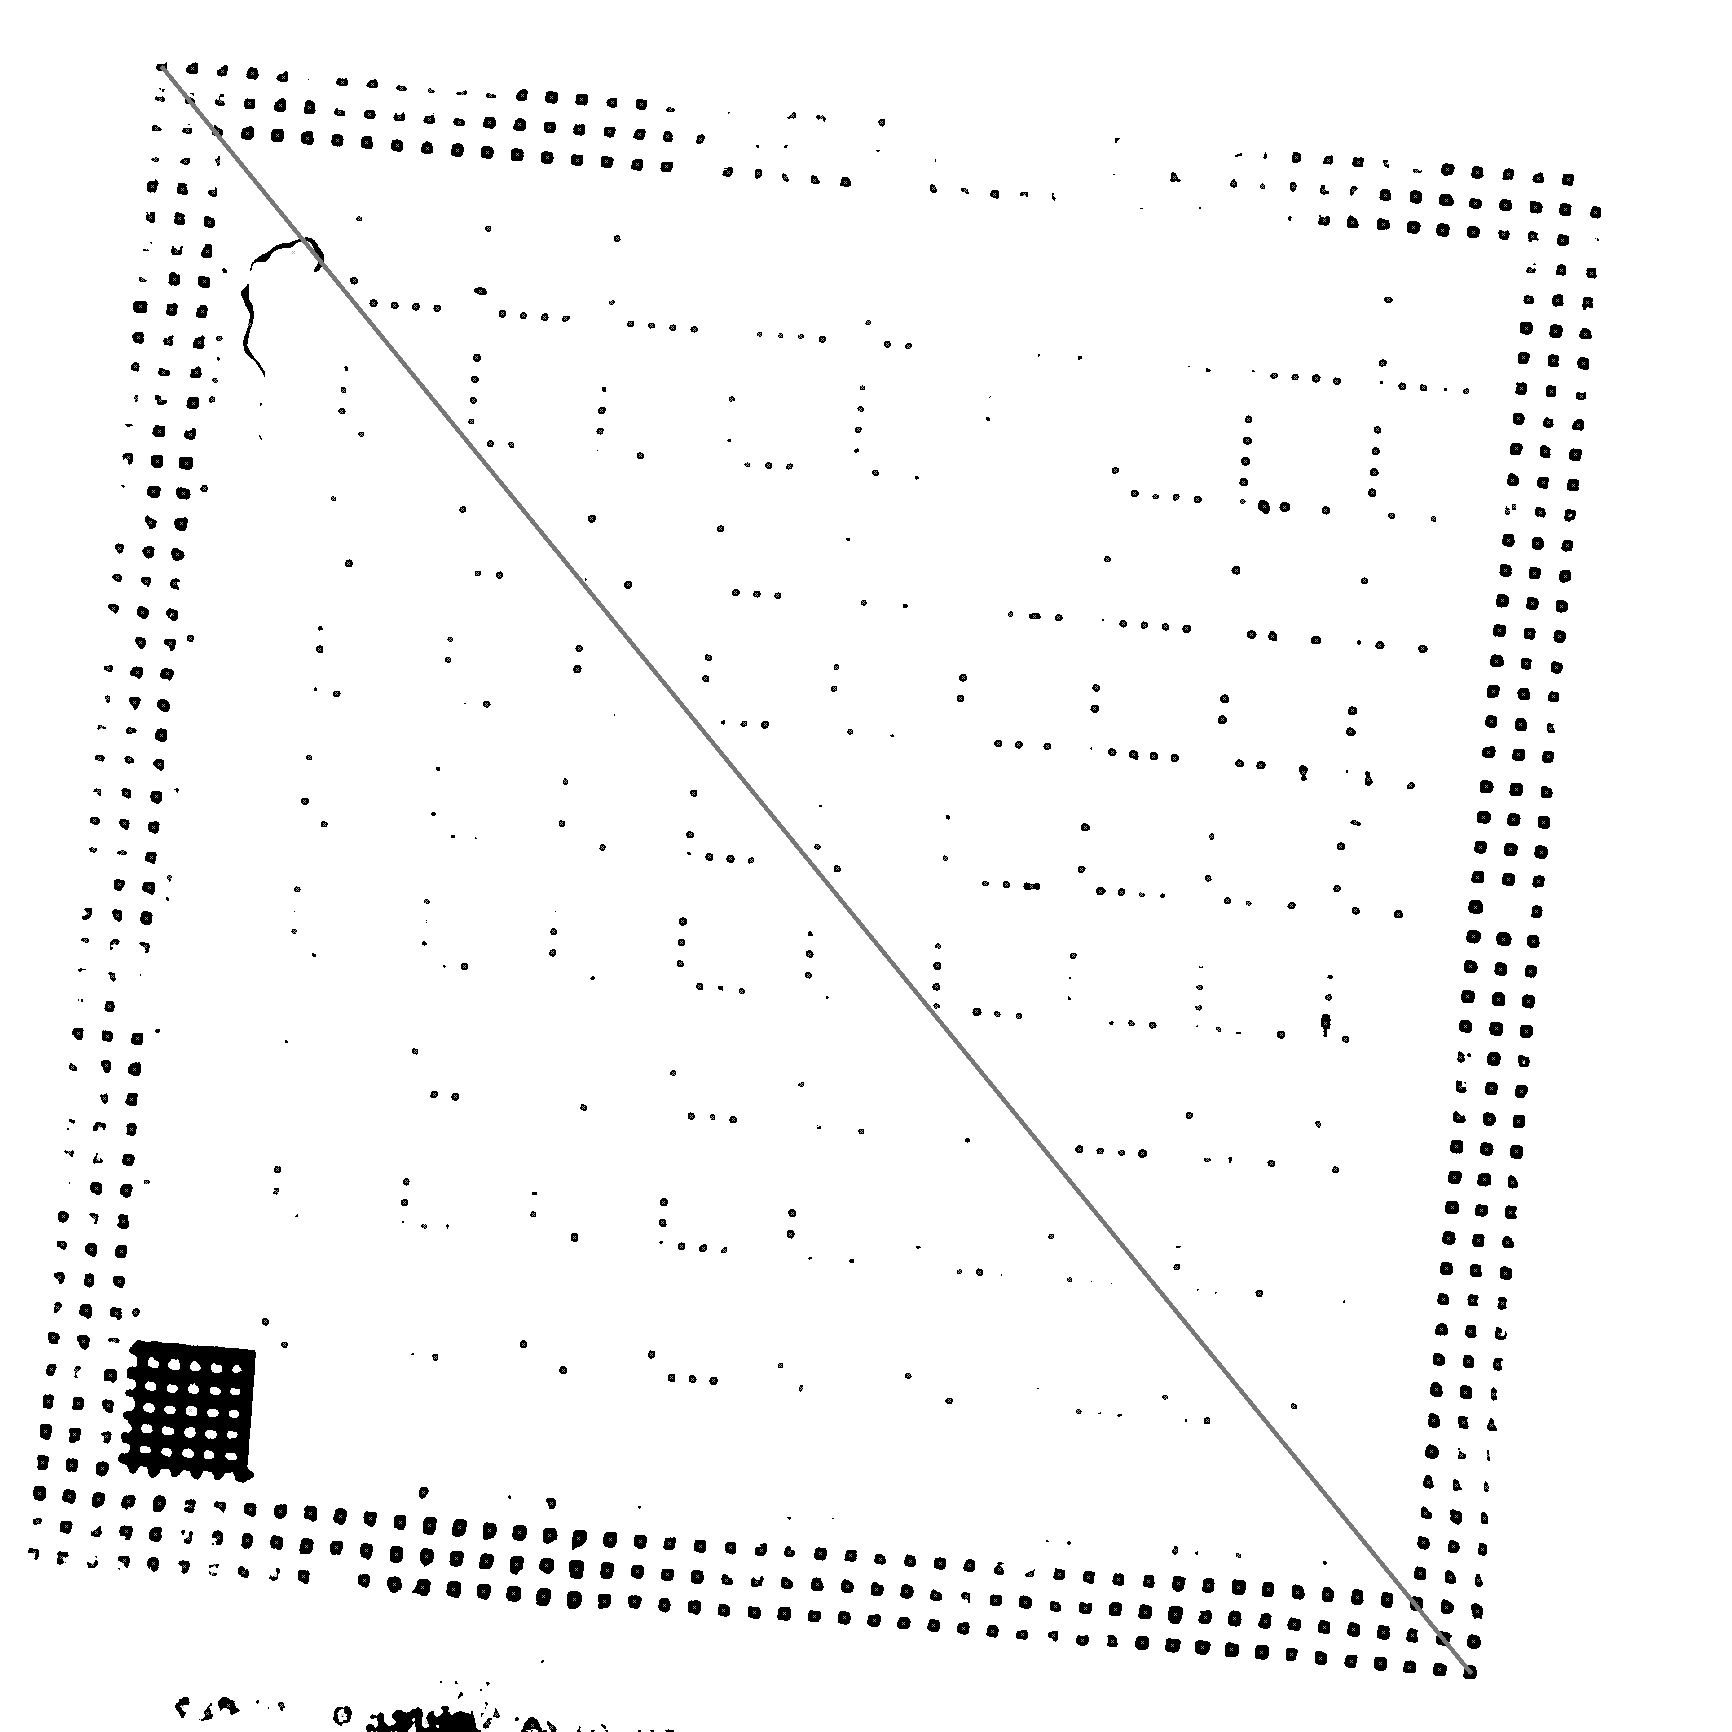

In [25]:


cf1_lr = lower_right(mp)
cf1_ul = upper_left(mp)
cf1_center = np.average([cf1_lr, cf1_ul],  axis = 0)
print("original cf1 ", cf1_lr, cf1_ul)

# print(cf1_center)
# image = cv2.line(im2.copy(), cf1_lr, cf1_ul, 120, 4) 
# c(image)

cf2_lr = lower_right(mp2)
cf2_ul = upper_left(mp2)
cf2_center = np.average([cf2_lr, cf2_ul],  axis = 0)
print("original cf2 ", cf2_lr, cf2_ul)

translation_cf2_to_cf1 = [- cf2_center[0] + cf1_center[0], - cf2_center[1] + cf1_center[1]]
# print(translation_cf2_to_cf1)

print("\nTRANSLATION NEEDED", translation_cf2_to_cf1, "\n")

translated_cf2_lr = [cf2_lr[0] + translation_cf2_to_cf1[0], cf2_lr[1] + translation_cf2_to_cf1[1]]
translated_cf2_ul = [cf2_ul[0] + translation_cf2_to_cf1[0], cf2_ul[1] + translation_cf2_to_cf1[1]]
t_cf2_center = np.average([translated_cf2_lr, translated_cf2_ul],  axis = 0)

print("translated c2", translated_cf2_lr, translated_cf2_ul)
print("and new center is", t_cf2_center)

# print(t_cf2_center)
image1 = cv2.line(im.copy(), cf1_lr, cf1_ul, 120, 4) 
c(image1)



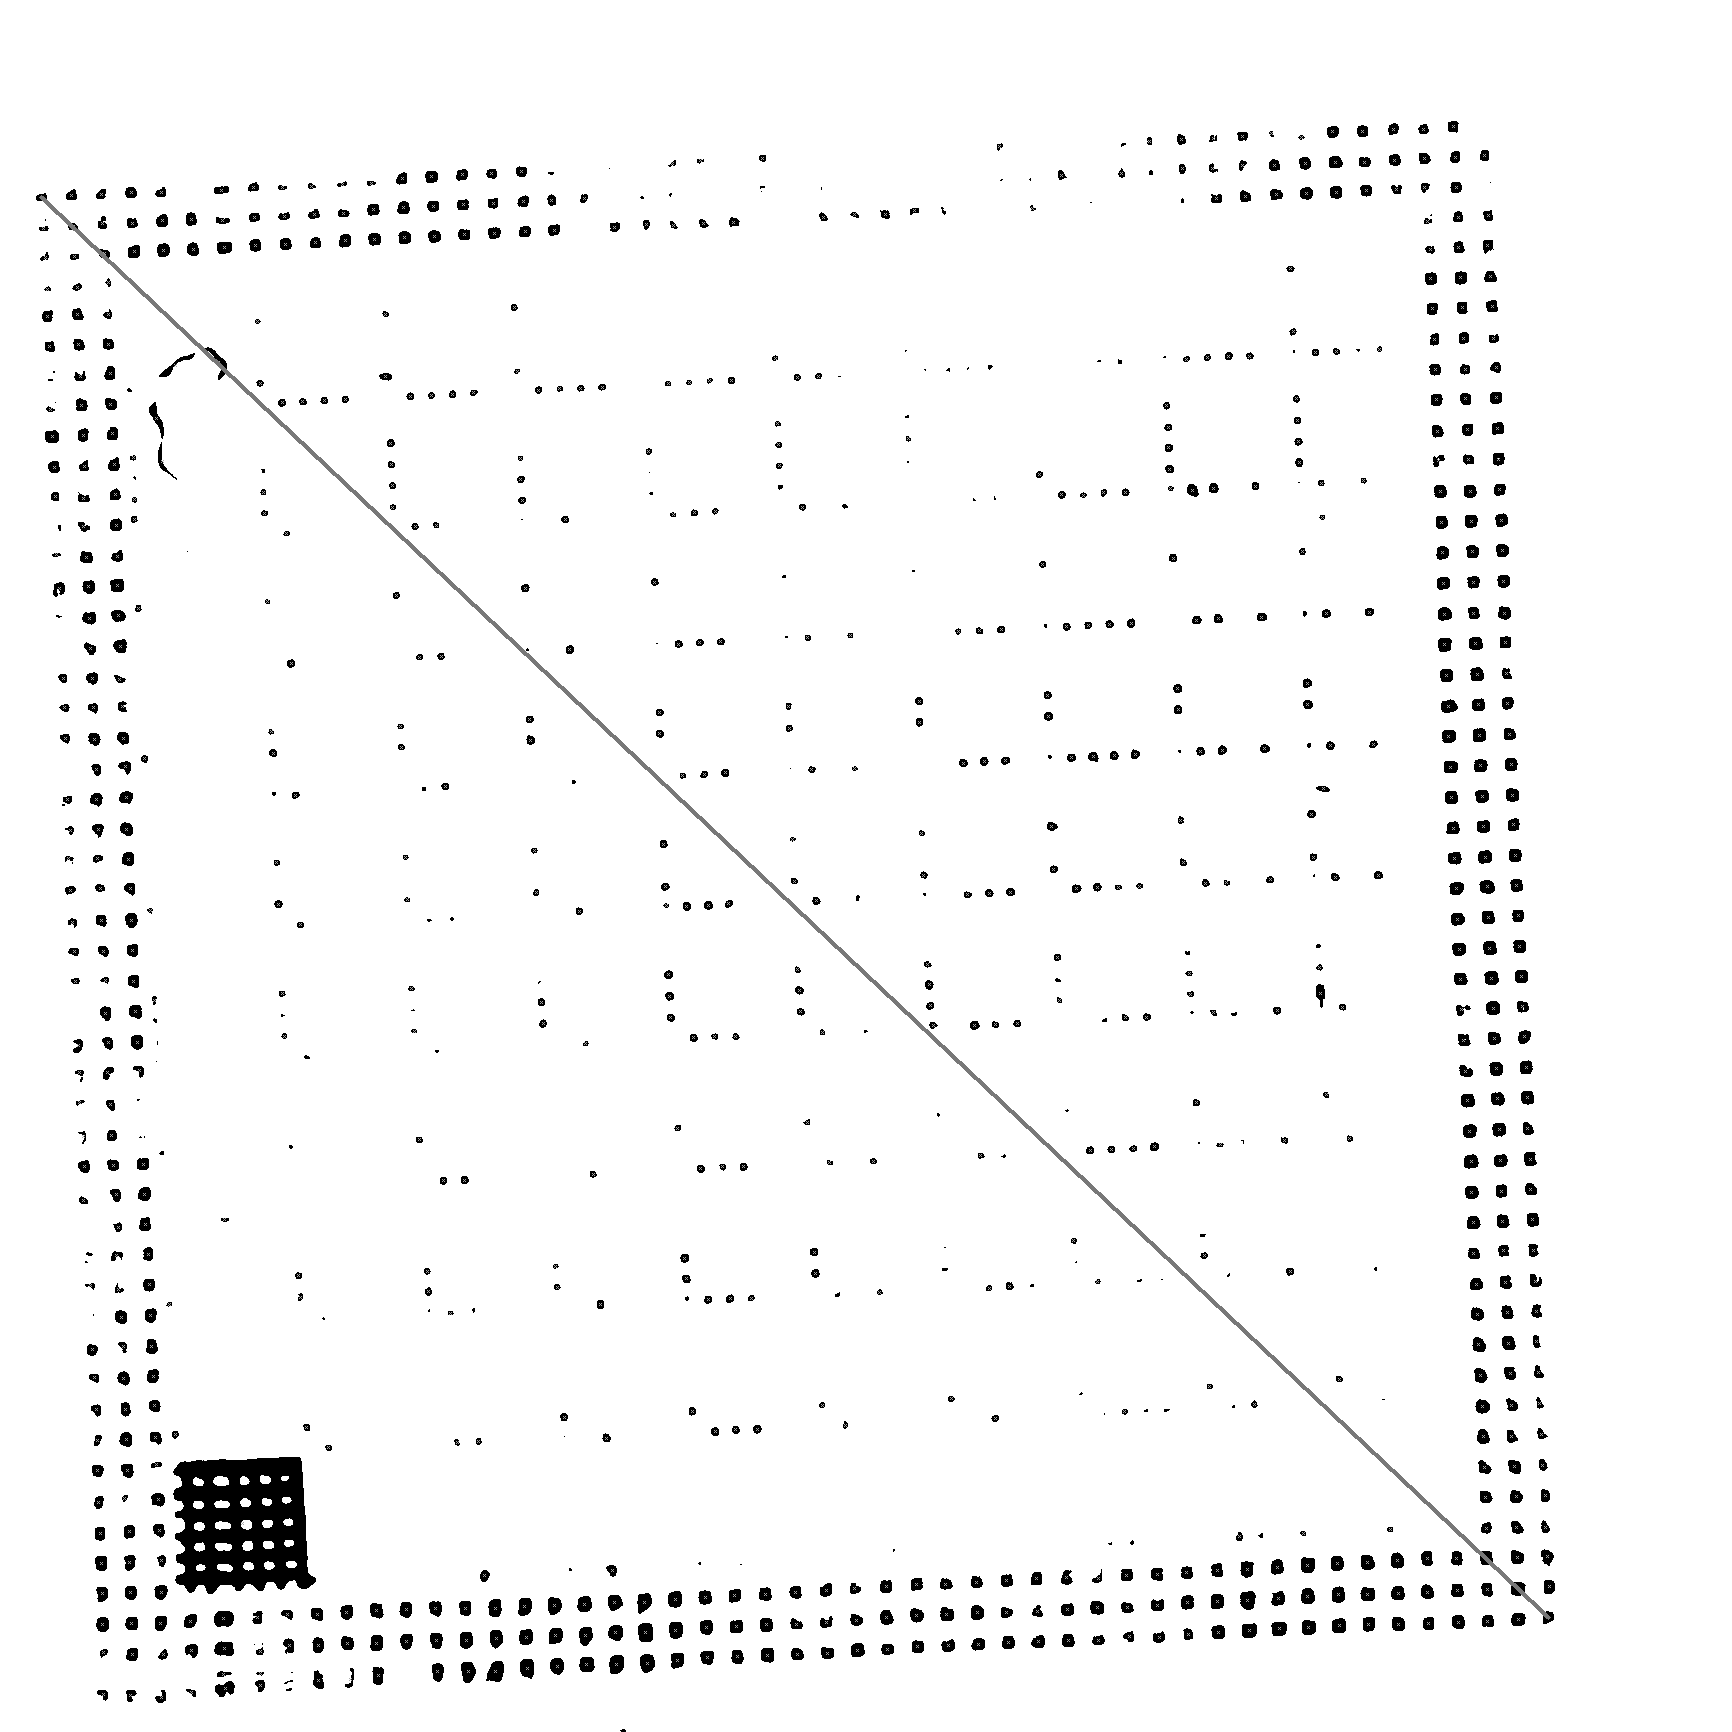

In [27]:
# print(t_cf2_center)
image2 = cv2.line(im2.copy(), cf2_lr, cf2_ul, 120, 4) 
c(image2)

In [28]:
import math

def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angle(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

lineA = (t_cf2_center, translated_cf2_ul)
lineB = (cf1_center, cf1_ul)

print(lineA)
print(lineB)

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])

ang = angle(slope1, slope2)
print('Angle in degrees = ', ang)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    
    # degrees = angle

    angle = angle*(math.pi/180)

    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy



(array([816. , 869.5]), [62.5, 159.5])
(array([816. , 869.5]), [162, 67])
Angle in degrees =  7.524091176736911


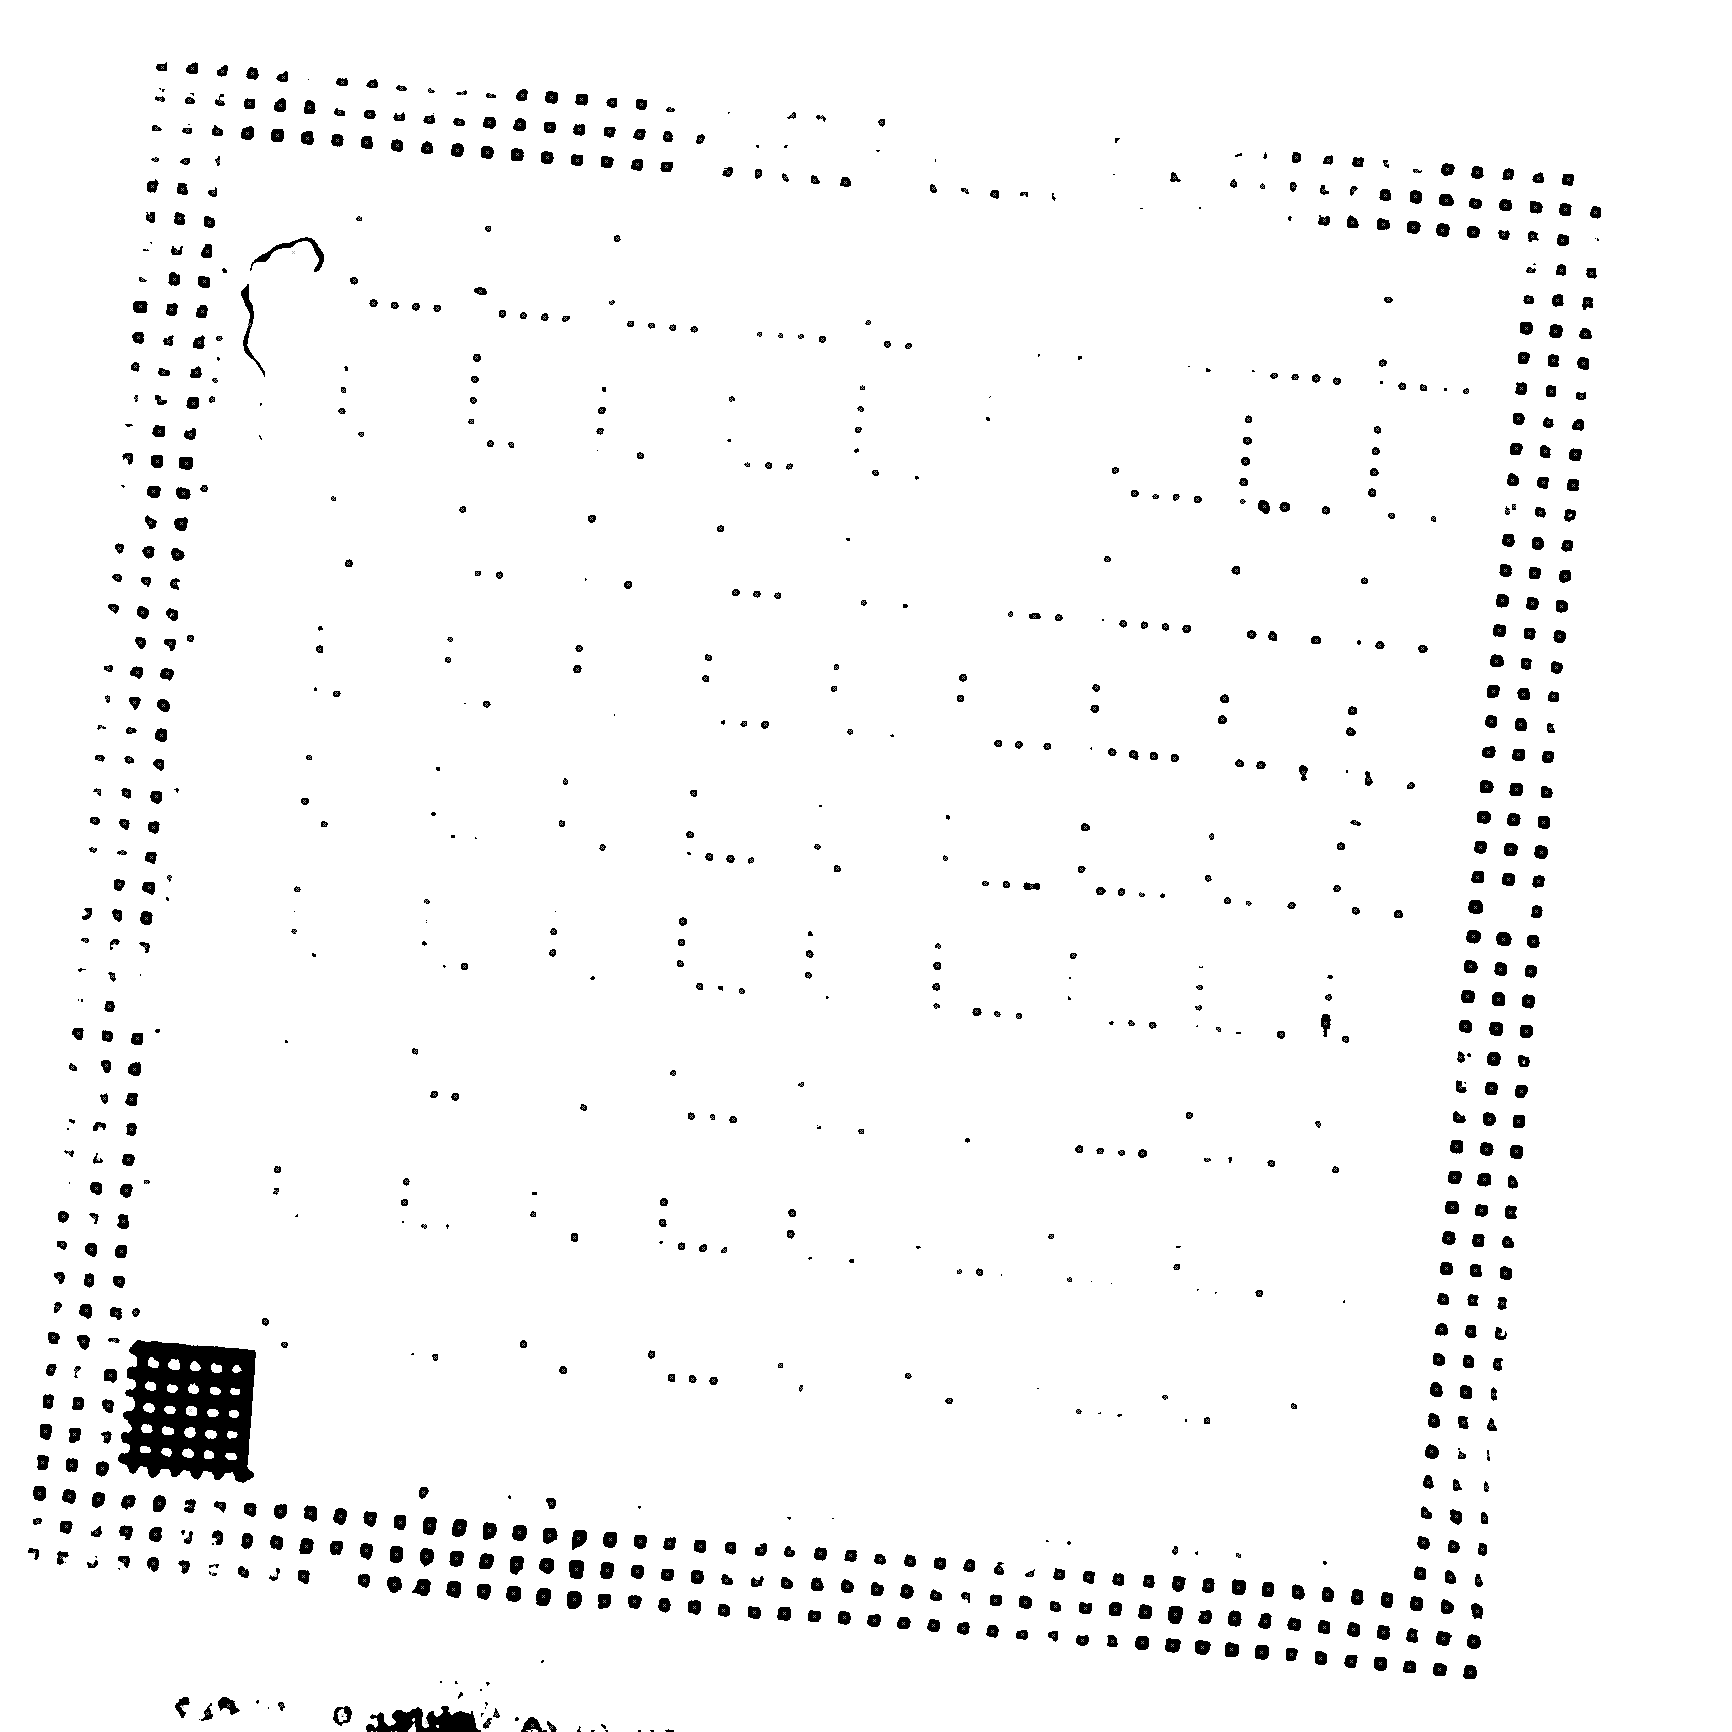

In [32]:
c(im) # original 

[21.5, -37.5]
shift success!


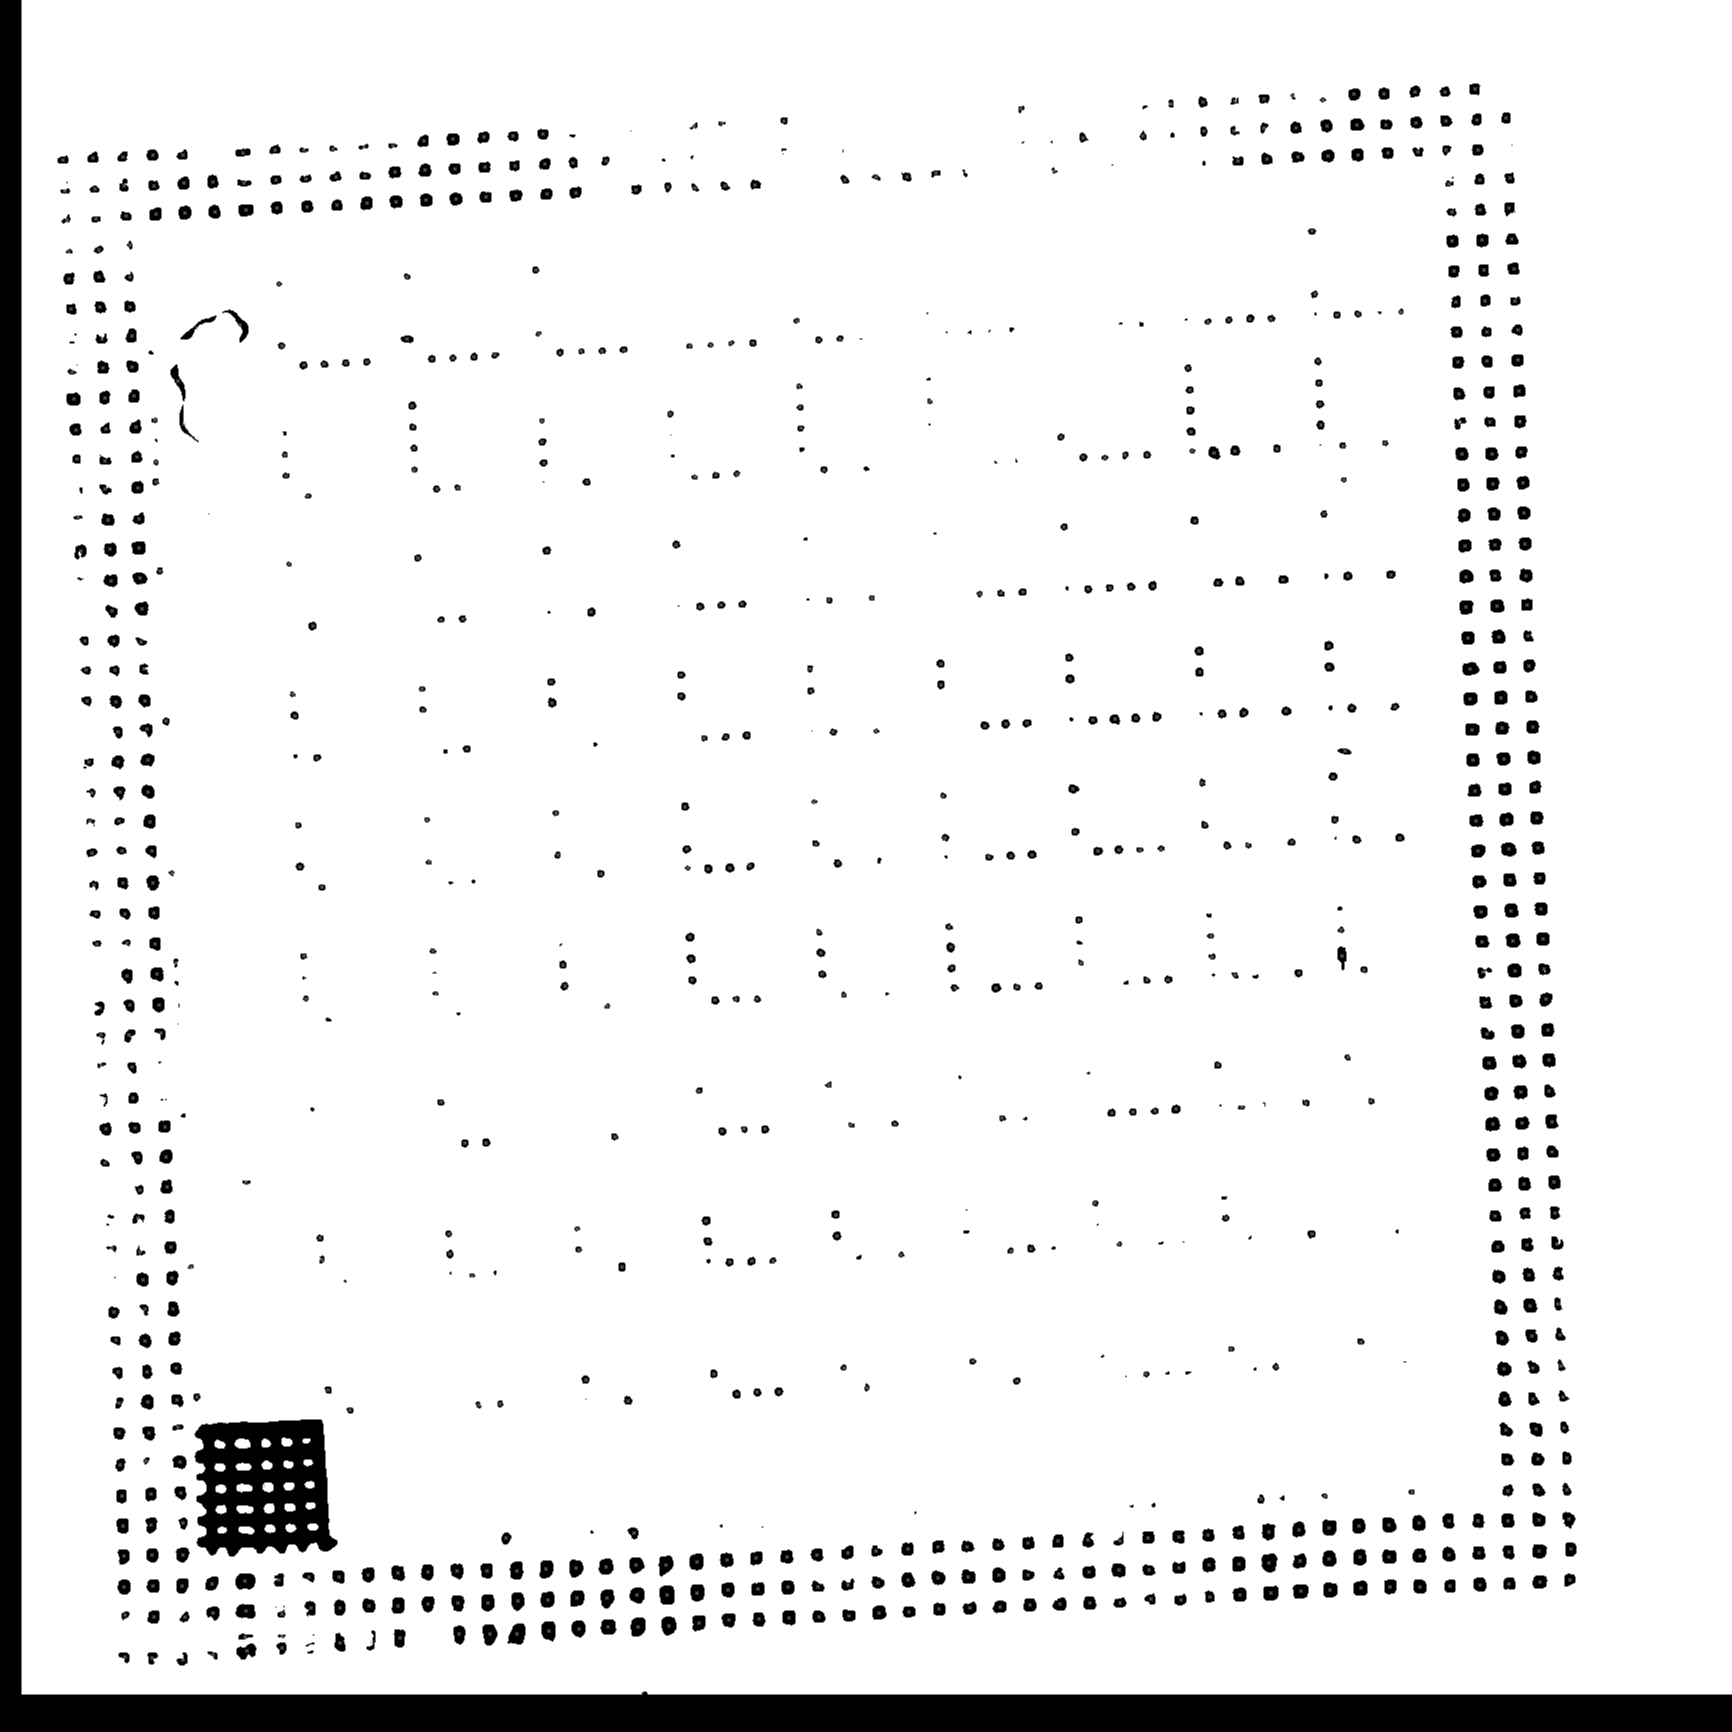

In [29]:
## FIRST, SHIFT
cp = im2.copy() 
print(translation_cf2_to_cf1)
translation_matrix = np.float32([ [1,0,translation_cf2_to_cf1[0]], [0,1,translation_cf2_to_cf1[1]] ])
img_translation = cv2.warpAffine(cp.copy(), translation_matrix, (new_size,new_size))

print("shift success!")
c(img_translation)

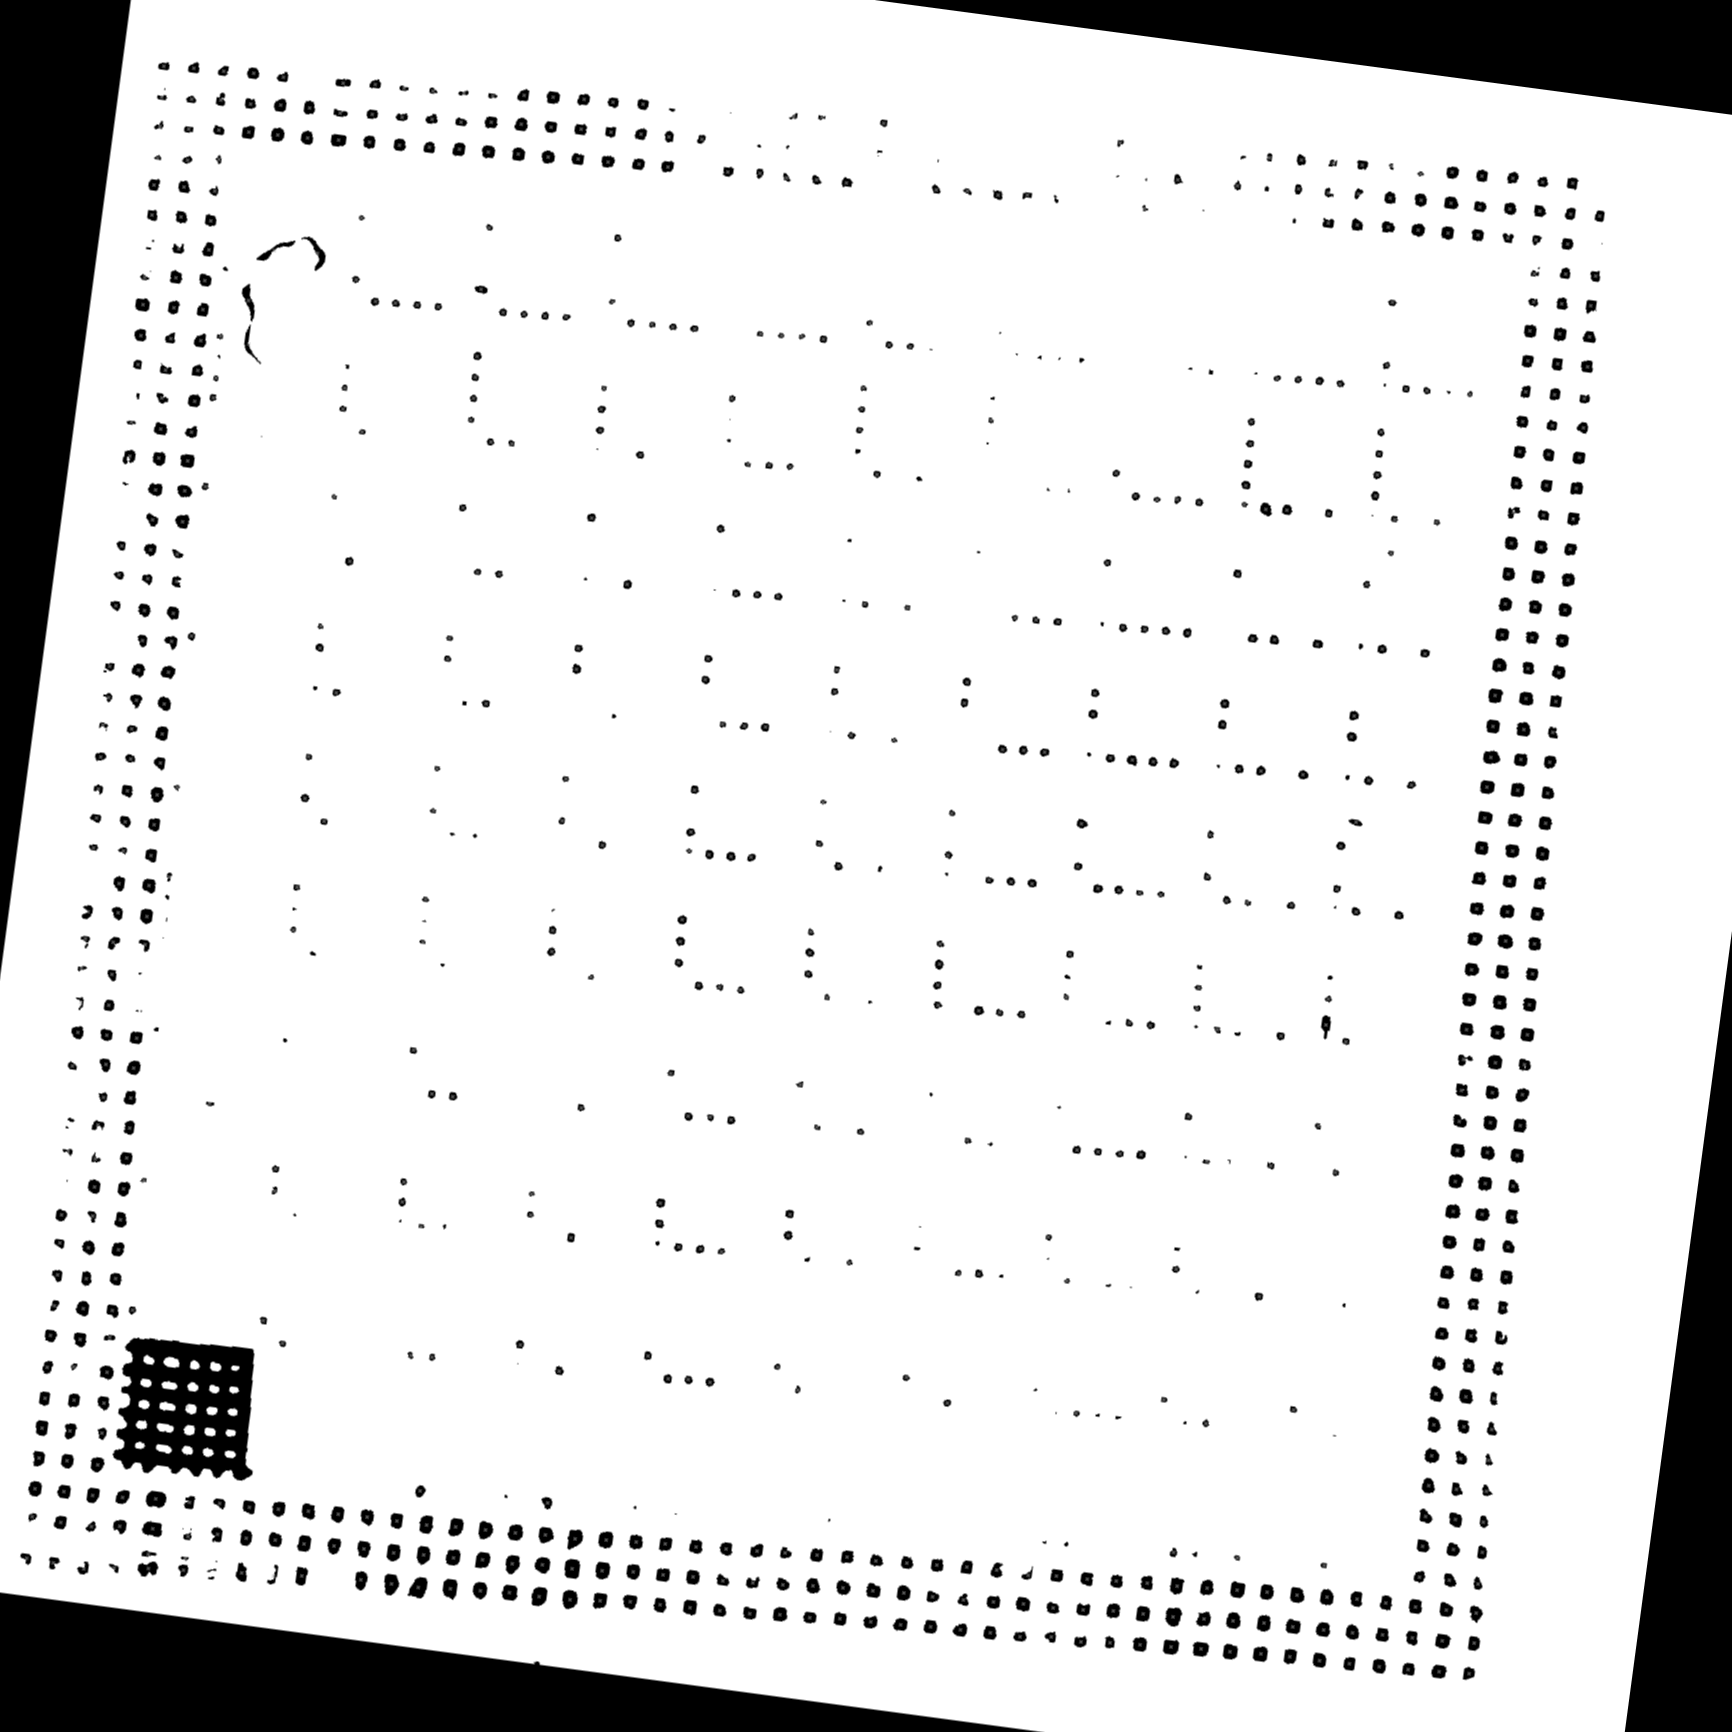

In [30]:
## THEN, ROTATE
warp_dst = img_translation

center = t_cf2_center
angle = - (ang + .1)
scale = 1
rot_mat = cv2.getRotationMatrix2D( center, angle, scale )

warp_rotate_dst = cv2.warpAffine(warp_dst, rot_mat, (warp_dst.shape[1], warp_dst.shape[0]))

# cp = warp_rotate_dst

c(warp_rotate_dst)

In [ ]:
# overlay


In [ ]:
# cp = brightfield_cy1
# ### Doing shifting 
# print(translation_cf2_to_cf1)
# translation_matrix = np.float32([ [1,0,translation_cf2_to_cf1[0]], [0,1,translation_cf2_to_cf1[1]] ])
# img_translation = cv2.warpAffine(cp.copy(), translation_matrix, (170000,17000))



In [35]:
# okay, now to apply to real image, we need to scale up the translation + the center of rotation



bf_layer = 2 # PRESET NEEDE

upscaled_translation = np.array(translation_cf2_to_cf1) * scale_down_factor
upscaled_center = t_cf2_center * scale_down_factor

print("translate from", translation_cf2_to_cf1, "to", upscaled_translation)
print("rotational center from", t_cf2_center, "to", upscaled_center)

###### don't change!
img_cy2 = Image.open(cy2_file)
img_cy2.seek(bf_layer) # navigate to brightfield
cp = np.array(img_cy2)
print("before padding", cp.shape)
cp = np.pad(cp, pad_width=((max_dim-y_cf2, 0), (0, max_dim-x_cf2)), mode = 'median')
print("after padding ", cp.shape)
######


# clip



new_size = (cp.shape[0])
cp = cv2.resize(cp, (new_size, new_size)) # 96.5% smaller = faster

# translating
translation_matrix = np.float32([ [1,0,translation_cf2_to_cf1[0] * 5], [0,1,translation_cf2_to_cf1[1] * 5] ])
img_translation = cv2.warpAffine(cp, translation_matrix, cp.shape)

# rotating
rot_mat = cv2.getRotationMatrix2D( t_cf2_center * 5, -(ang + .1), 1 )
warp_rotate_dst = cv2.warpAffine(img_translation, rot_mat, (img_translation.shape[1], img_translation.shape[0]))


c(warp_rotate_dst).save(cy2_shifted_file)


### also don't forget the padded cycle1!
img_cy1 = Image.open(cy1_file)
img_cy1.seek(bf_layer) # navigate to brightfield
cp = np.array(img_cy1)
print("before padding", cp.shape)
cp = np.pad(cp, pad_width=((max_dim-y_cf1, 0), (0, max_dim-x_cf1)), mode = 'median')
print("after padding ", cp.shape)
c(cp).save(cy1_shifted_file)


translate from [21.5, -37.5] to [ 21.5 -37.5]
rotational center from [816.  869.5] to [816.  869.5]
before padding (17035, 17467)
after padding  (17079, 17467)
before padding (17472, 16668)
after padding  (17472, 16741)


In [13]:
img_cy1 = Image.open(cy1_file)
img_cy1.seek(2) # navigate to brightfield
brightfield_cy1 = np.array(img_cy1)
brightfield_cy1 = (brightfield_cy1/256).astype('uint8') # don't need the whole range of values, so this reduces mem size, + improves access speed
print(brightfield_cy1.shape)
brightfield_cy1_reduced = cv2.resize(brightfield_cy1, (np.array(brightfield_cy1.T.shape) // 10) ) # 96.5% smaller = faster
print(brightfield_cy1_reduced.shape)

(17472, 16668)
(1747, 1666)


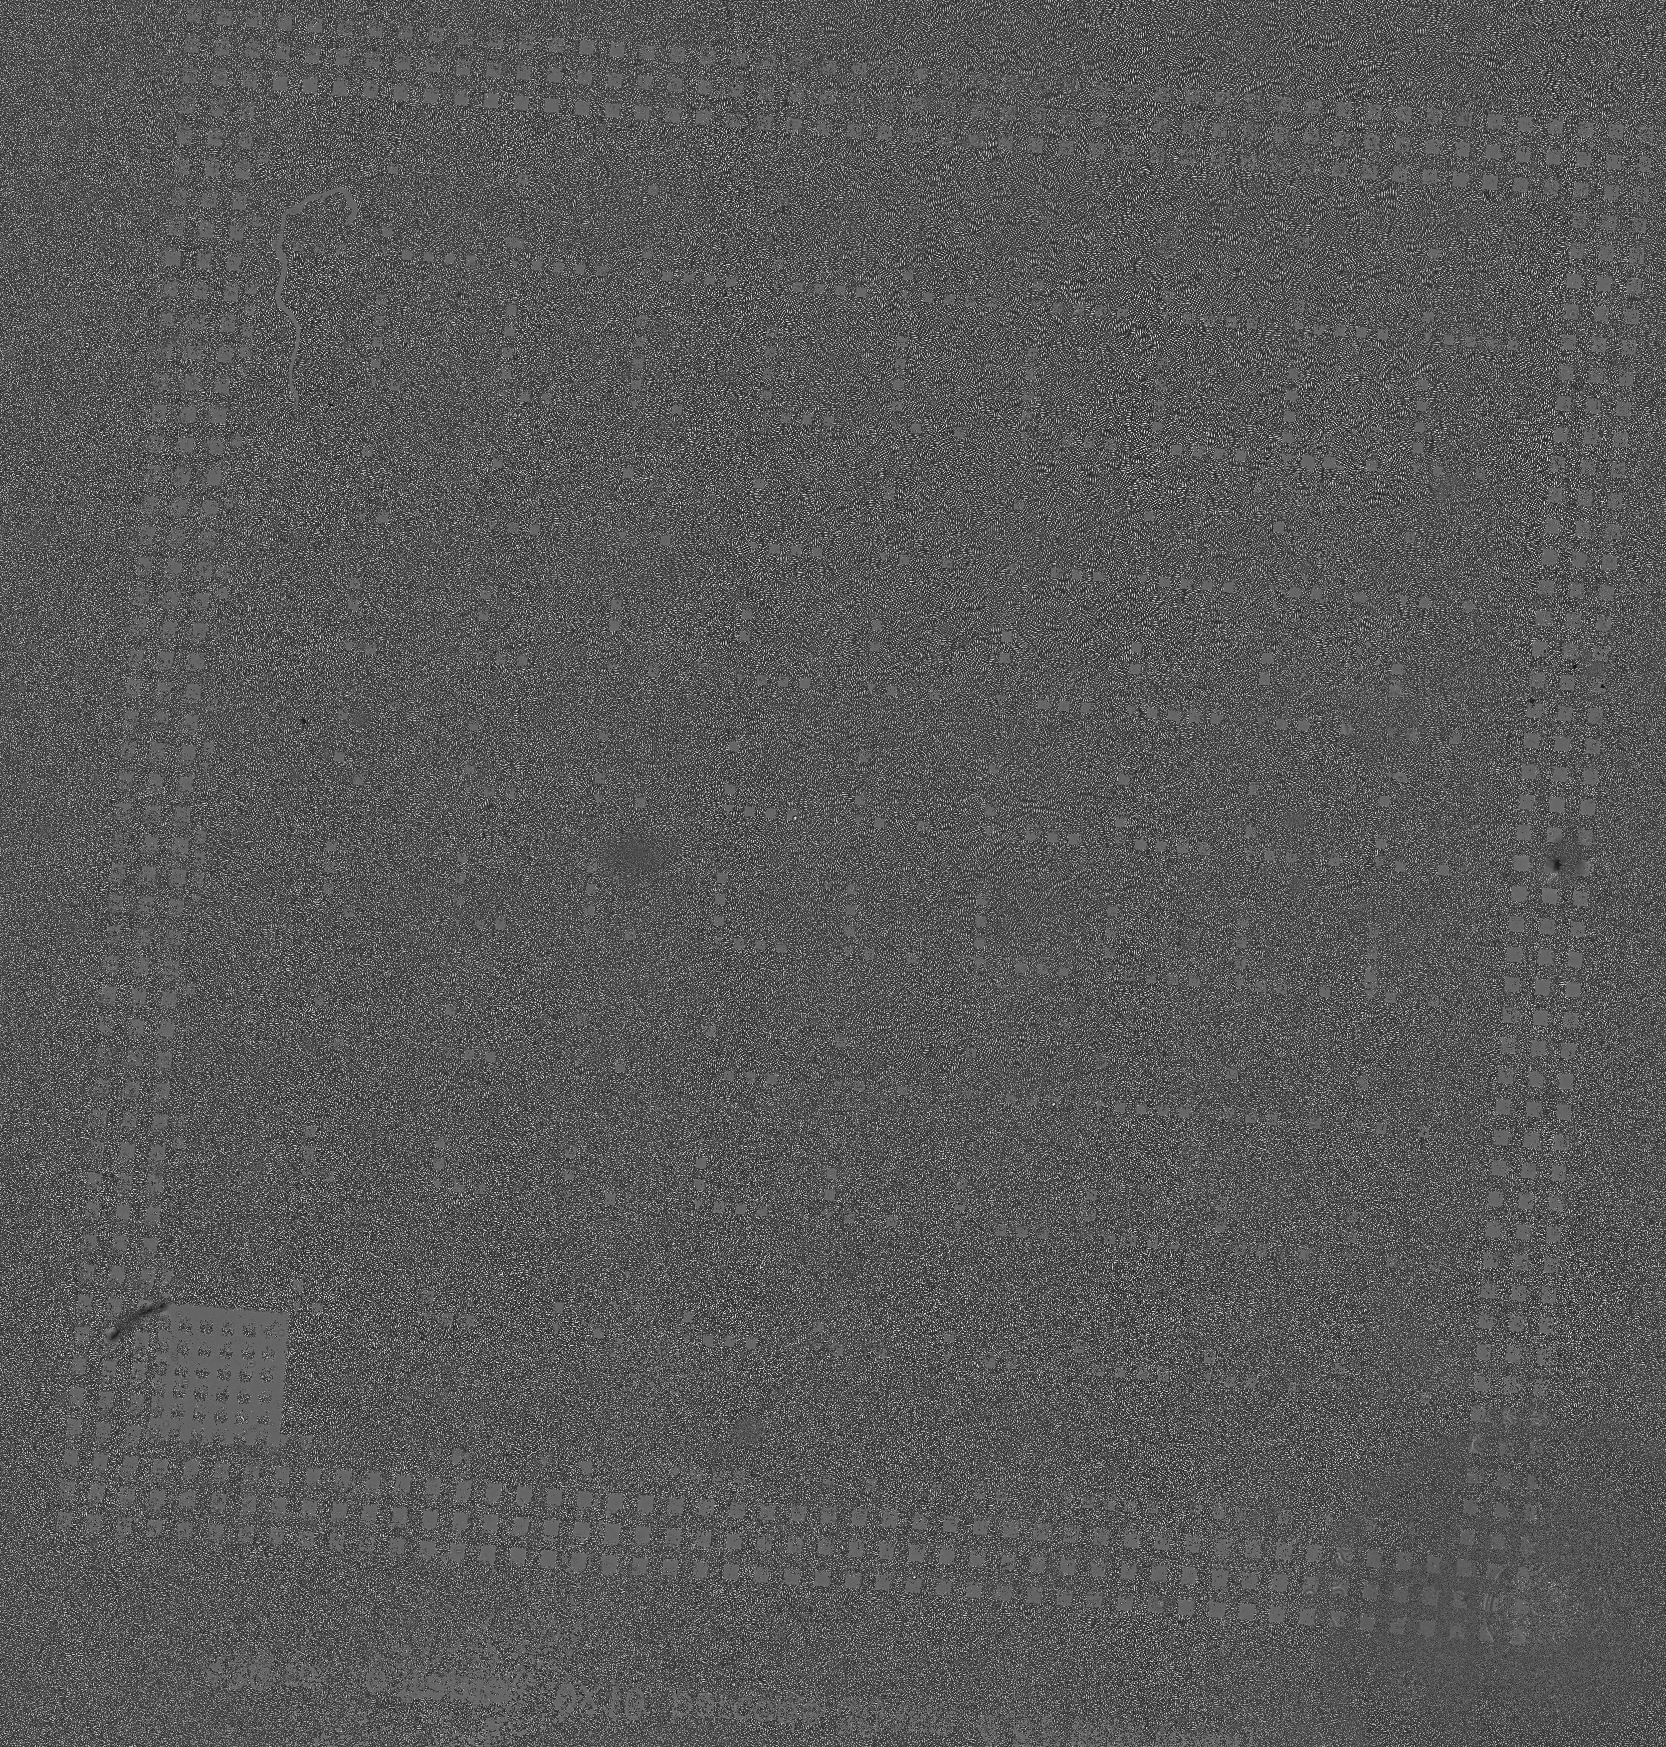

In [14]:
c(brightfield_cy1_reduced)

In [ ]:
img_cy2 = Image.open(cy2_file)
img_cy2.seek(layer_to_align) # navigate to brightfield
brightfield_cy2 = np.array(img_cy2)
brightfield_cy2 = (brightfield_cy2/256).astype('uint8') 

c(brightfield_cy2)